In [1]:
#standard python packages
import os 
import sys
import random
import warnings

#data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image #we will need this for conversion from images (.png) into numpy arrays
%matplotlib inline

# import cv2

from tqdm import tqdm_notebook, tnrange #progress bar
from itertools import chain # chain('ABC', 'DEF') --> A B C D E F
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize

#tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

## Unzip files
Here, we unzip the contetns of test.zip and test.zip from the "/kaggle/input" folder into the "/kaggle/working" folder.
After unzipping, we print out the contents of the "/kaggle/working" folder for inspection

In [2]:
print("___/kaggle/input folder___")
for dirname, _, filenames in os.walk('/kaggle/input/tgs-salt-identification-challenge/'):
    for filename in filenames:
        print(filename)

___/kaggle/input folder___
depths.csv
sample_submission.csv
train.zip
competition_data.zip
test.zip
train.csv
flamingo.zip


In [3]:
# #unzip contents
! unzip /kaggle/input/tgs-salt-identification-challenge/train.zip -d /kaggle/working/train
! unzip /kaggle/input/tgs-salt-identification-challenge/test.zip -d /kaggle/working/test

Archive:  /kaggle/input/tgs-salt-identification-challenge/train.zip
   creating: /kaggle/working/train/images/
   creating: /kaggle/working/train/masks/
  inflating: /kaggle/working/train/images/8d08955cdf.png  
  inflating: /kaggle/working/train/images/e045664b46.png  
  inflating: /kaggle/working/train/images/4989c6509e.png  
  inflating: /kaggle/working/train/images/fff4eb4941.png  
  inflating: /kaggle/working/train/images/3a310860a3.png  
  inflating: /kaggle/working/train/images/7a696bb878.png  
  inflating: /kaggle/working/train/images/8d3ee9356b.png  
  inflating: /kaggle/working/train/images/213e0a9f7b.png  
  inflating: /kaggle/working/train/images/78f17697f2.png  
  inflating: /kaggle/working/train/images/bd20d18369.png  
  inflating: /kaggle/working/train/images/de08c5a3b7.png  
  inflating: /kaggle/working/train/images/f06ef6c8b7.png  
  inflating: /kaggle/working/train/images/b2d02516e1.png  
  inflating: /kaggle/working/train/images/5edb37f5a8.png  
  inflating: /kaggle/

# Exploratory Data Analysis (EDA)

> Keep your friends close but your data closer.

Resources: https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15

Here, we perform EDA to understand our data better. First, we can display some images to ensure that we have extracted our raw data correctly.



In [4]:
path_train = '/kaggle/working/train/'
path_test = '/kaggle/working/test/'

#specifying index of 2 will only retrieve the list of filenames, and not the absolute paths.
train_image_ids = next(os.walk(path_train+"images"))[2]
train_mask_ids = next(os.walk(path_train+"masks"))[2] 
test_image_ids = next(os.walk(path_test+"images"))[2]

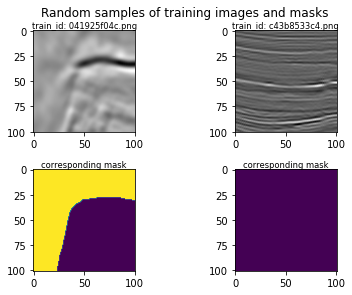

In [5]:
#Now let's inspect the data visually by extracting some random samples

def visualize_raw_data(n): #n, number of examples to display

    # plt.figure(figsize = (20,10))
    fig, axs = plt.subplots(2, n)
    fig.suptitle('Random samples of training images and masks', va = 'baseline' ) #va = 'baseline' prevents intersection with the sub titles.

    for i in range(n):
        ran_index = np.random.randint(0, len(train_image_ids))

        img = image.imread(path_train + 'images/' + train_image_ids[ran_index] )
        img_mask = image.imread(path_train + 'masks/' + train_mask_ids[ran_index] )
        
        axs[0, i].set_title("train_id: {}".format(train_image_ids[ran_index]),fontsize = 'small', pad=2)
        axs[0, i].imshow(img)
        axs[1, i].set_title("corresponding mask",fontsize = 'small', pad=2)
        axs[1, i].imshow(img_mask)

    plt.tight_layout()
    plt.show()

visualize_raw_data(2)

# Data Pre-processing

1. We resize both the train and the test images
2. We normalize the data:
2a. The two most discussed data scaling methods are Normalization and Standardization: Normalization typically means rescales the values into a range of [0,1]. Standardization typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance). Here, we choose to normalize the data as standardization is normally used when there are many features of different units we want to put onto the same scale.

In [6]:
path_train = '/kaggle/working/train/'
path_test = '/kaggle/working/test/'

# Further preprocessing of data
# 1. resize images to input size and convert to numpy arrays
# 2. Normalize the data to a range between 0 and 1
def preprocess_data(inp_w, inp_h, inp_c, path_train, path_test):

    # PART 1: Resize train, mask and test images
    X_train_ = np.zeros((len(train_image_ids), inp_w, inp_h, inp_c), dtype=np.uint8)
    Y_train_ = np.zeros((len(train_image_ids), inp_w, inp_h, inp_c), dtype=np.bool)
    X_test_ = np.zeros((len(test_image_ids), inp_w, inp_h, inp_c), dtype=np.uint8)

    sys.stdout.flush() #write everything in the buffer to the terminal, even if normally it would wait before doing so. 

    # Iterate through array of train_ids
    for n, id_ in tqdm_notebook(enumerate(train_image_ids), total = len(train_image_ids)):
        #load the images
        #we extract the second channel from the 3 channel image as our numpy array
        img_array = img_to_array(load_img(path_train + '/images/' + id_ ))[:,:,1]
        mask_array = img_to_array(load_img(path_train + '/masks/' + id_ ))[:,:,1]

        #resize the arrays. 
        #anti_aliasing: Set anti_aliasing to true, thereby applying a Gaussian filter to smooth the image 
        #prior to down-scaling. It is crucial to filter when down-sampling the image to avoid aliasing artifacts. 
        #preserve_range: Keep the original range of values. 
        X_train_[n] = resize(img_array, (inp_w, inp_h, inp_c), mode='constant', anti_aliasing=True, preserve_range=True) 
        Y_train_[n] = resize(mask_array, (inp_w, inp_h, inp_c), mode='constant', anti_aliasing=True, preserve_range=True)

    sizes_test = []
    # Iterate through array of test_ids
    for n, id_ in tqdm_notebook(enumerate(test_image_ids), total = len(test_image_ids)):
        test_array = img_to_array(load_img(path_test + '/images/' + id_))[:,:,1]
        
        sizes_test.append([test_array.shape[0], test_array.shape[1]])
        X_test_[n] = resize(test_array, (inp_w, inp_h, inp_c), mode='constant', anti_aliasing=True, preserve_range=True)
    
    # PART 2A: Normalize the arrays
#     X_train_ = X_train_/255 
#     X_test_ = X_test_/255
    
    return X_train_, Y_train_, X_test_, sizes_test

X_train_, Y_train_, X_test, sizes_test = preprocess_data(128, 128, 1, '/kaggle/working/train/', '/kaggle/working/test/')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [7]:
#Train Test Split
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train_, Y_train_, test_size=0.1)
del X_train_
del Y_train_

print("x_train shape: {}, y_train shape: {}".format(X_train.shape, Y_train.shape))
print("x_val shape: {}, y_val shape: {}".format(X_val.shape, Y_val.shape))

x_train shape: (3600, 128, 128, 1), y_train shape: (3600, 128, 128, 1)
x_val shape: (400, 128, 128, 1), y_val shape: (400, 128, 128, 1)


The below cell takes up alot of RAM, need to rewrite without the function

In [8]:
# #n, number of examples to display
# def visualize_resized_data(n, X_train_, Y_train_): 

#     # plt.figure(figsize = (20,10))
#     fig, axs = plt.subplots(2, n)
#     fig.suptitle('Random samples of training images and masks', va = 'baseline' ) #va = 'baseline' prevents intersection with the sub titles.

#     for i in range(n):

#         ran_index = np.random.randint(0, X_train_.shape[0])
        
#         X = X_train_[ran_index]
#         # Because Y_train datatype is bool, we need to convert it to float32
#         # np.squeeze removes single-dimensional entries from the shape of an array.
#         Y = Y_train_[ran_index].astype(np.float32) 

#         axs[0, i].set_title("train_id: {}".format(train_image_ids[ran_index]),fontsize = 'small', pad=2)
#         axs[0, i].imshow(np.dstack((X, X, X)) )
        
#         axs[1, i].set_title("corresponding mask",fontsize = 'small', pad=2)
#         axs[1, i].imshow(np.dstack((Y, Y, Y)) )

#     plt.tight_layout()
#     plt.show()
    
# visualize_resized_data(3, X_train, Y_train)

In [9]:
#Image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center = False, 
                             samplewise_center = False,
                             featurewise_std_normalization = False,
                             samplewise_std_normalization = False,
                             zca_whitening = False,
#                              rotation_range = 45, #perhaps to change this is 90?
#                              zoom_range = 0.1,
#                              width_shift_range = 0.15,
#                              height_shift_range = 0.15,
                             horizontal_flip = True,
                             vertical_flip = True)
datagen.fit(X_train)

# Model Training

### From tensorflow documentation
> Mean IoU is a common evaluation metric for semantic image segmentation, which first computes the IOU for each semantic class and then computes the average over classes. IOU is defined as follows:
IOU =  true_positive / (true_positive+ false_positive + false_negative)
The predictions are accumulated in a confusion matrix, weighted by sample_weight and the metric is then calculated from it.

In [10]:
# #Encoder
# def EncoderUnit(filters, kernel_size, activation, padding, input_layer):
#     x1 = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(input_layer)
#     x2 = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(x1)
#     p1 = MaxPooling2D((2,2))(x2)
#     return p1, x2

# def ConvUnit(filters, kernel_size, activation, padding, input_layer):
#     x1 = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(input_layer)
#     x2 = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(x1)
#     return x2

# def Decoder(filters, kernel_size, strides, padding, input_layer, skip_layer):
#     u1 = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(input_layer)
#     concat = concatenate([u1, skip_layer]) #shortcut
#     return concat

In [11]:
# #Build U-Net Model 
# inputs = Input(shape=(128, 128, 1))
# # s = Lambda(lambda x: x/255) (inputs)

# Encoder1, Conv1 = EncoderUnit(8, (3,3), 'relu', 'same', inputs)
# Encoder2, Conv2 = EncoderUnit(16, (3,3), 'relu', 'same', Encoder1)
# Encoder3, Conv3 = EncoderUnit(32, (3,3), 'relu', 'same', Encoder2)
# Encoder4, Conv4 = EncoderUnit(64, (3,3), 'relu', 'same', Encoder3)

# Conv5 = ConvUnit(8, (3,3), 'relu', 'same', Encoder4)

# Decoder6 = Decoder(64, (2,2), (2,2), 'same', input_layer=Conv5, skip_layer=Conv4)
# Conv6 = ConvUnit(8, (3,3), 'relu', 'same', Decoder6)

# Decoder7 = Decoder(64, (2,2), (2,2), 'same', input_layer=Conv6, skip_layer=Conv3)
# Conv7 = ConvUnit(8, (3,3), 'relu', 'same', Decoder7)

# Decoder8 = Decoder(64, (2,2), (2,2), 'same', input_layer=Conv7, skip_layer=Conv2)
# Conv8 = ConvUnit(8, (3,3), 'relu', 'same', Decoder8)

# Decoder9 = Decoder(64, (2,2), (2,2), 'same', input_layer=Conv8, skip_layer=Conv1)
# Conv9 = ConvUnit(8, (3,3), 'relu', 'same', Decoder9)

# outputs=Conv2D(1, (1,1), activation='sigmoid')(Conv9)

# model = Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
# # model.summary()

# # tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
inputs = Input((128, 128, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4]) #shortcut
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3]) #shortcut
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2]) #shortcut
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
# model.summary()

In [13]:
#define callbacks
#earlystopper stops the the training after the metrics stop improving for a number of epochs(defined by patience).
#checkpointer saves the model after each epoch

earlystopper= EarlyStopping(patience=5, verbose=1)

checkpointer = ModelCheckpoint('/kaggle/working/model-tgs-salt-1.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [14]:
# hyperparameters
batch_size = 8
epochs = 15

history = model.fit(datagen.flow(X_train, Y_train, batch_size = batch_size),
                   epochs=epochs,
                   validation_data = (X_val, Y_val),
                    verbose = 1,
#                     steps_per_epoch=steps_per_epoch,
                    callbacks=[earlystopper, checkpointer])

Epoch 1/15
446/450 [============================>.] - ETA: 0s - loss: 0.5707 - mean_io_u: 0.3739
Epoch 00001: val_loss improved from inf to 0.54806, saving model to /kaggle/working/model-tgs-salt-1.h5
450/450 [==============================] - 6s 14ms/step - loss: 0.5709 - mean_io_u: 0.3737 - val_loss: 0.5481 - val_mean_io_u: 0.3778
Epoch 2/15
450/450 [==============================] - ETA: 0s - loss: 0.5597 - mean_io_u: 0.3737
Epoch 00002: val_loss improved from 0.54806 to 0.53535, saving model to /kaggle/working/model-tgs-salt-1.h5
450/450 [==============================] - 5s 12ms/step - loss: 0.5597 - mean_io_u: 0.3737 - val_loss: 0.5353 - val_mean_io_u: 0.3778
Epoch 3/15
447/450 [============================>.] - ETA: 0s - loss: 0.5512 - mean_io_u: 0.3737
Epoch 00003: val_loss improved from 0.53535 to 0.52238, saving model to /kaggle/working/model-tgs-salt-1.h5
450/450 [==============================] - 6s 13ms/step - loss: 0.5508 - mean_io_u: 0.3737 - val_loss: 0.5224 - val_mean_

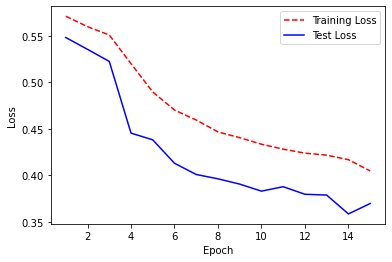

In [15]:
my_training_loss = history.history['loss']
my_test_loss = history.history['val_loss']
my_epoch_count = range(1, len(my_training_loss) + 1)
plt.plot(my_epoch_count, my_training_loss, 'r--')
plt.plot(my_epoch_count, my_test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
#Predict on train, val and test set
model = load_model('/kaggle/working/model-tgs-salt-1.h5', custom_objects={'mean_iou': tf.keras.metrics.MeanIoU(num_classes=2)})
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)

#threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

563/563 [==============================] - 5s 10ms/step


In [17]:
#create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)): # tnrange is a shortcut for tqdm_notebook(xrange(*args), **kwargs).
    preds_test_upsampled.append(resize(
                                    np.squeeze(preds_test[i]), 
                                    (sizes_test[i][0], sizes_test[i][0]), 
                                    mode='constant', 
                                    preserve_range=True))
preds_test_upsampled[0].shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


(101, 101)

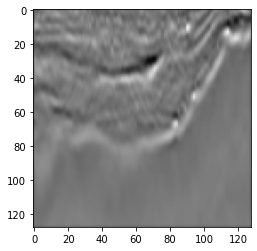

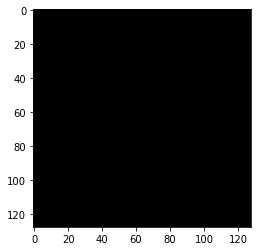

In [18]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
# plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
# plt.show()
# tmp = np.squeeze(Y_train[ix]).astype(np.float32)
# plt.imshow(np.dstack((tmp,tmp,tmp)))
# plt.show()


tmp = X_test[ix]
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [19]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs
    
pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_image_ids))}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [20]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')